Taken from the Qiskit notebook for Deutsch-Jozsa

# Deutsch-Jozsa algorithm (generalized)

In [1]:
# initialization
import numpy as np
from datetime import datetime
from depolar import depolarizing_channel

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [10]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate, b_str

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    depolarizing_channel(dj_circuit,n,decoherence_percent)
    dj_circuit.h(n)
    depolarizing_channel(dj_circuit,n,decoherence_percent)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
        depolarizing_channel(dj_circuit,qubit,decoherence_percent)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
        depolarizing_channel(dj_circuit,n,decoherence_percent)
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

def dj_mult(spread, n, trials):
    for i in range(trials):
        output = str(i)
        oracle_gate, oracle_func = dj_oracle(spread, n)
        output = output + ": " + str(oracle_func) + " |"
        dj_circuit = dj_algorithm(oracle_gate, n)
        results = execute(dj_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1024).result()
        answer = results.get_counts()
        output = output + str(answer) + "\n"
        f.write(output)

The variable `decoherence_percent` is the chance that a depolarizing channel will appear after an operation, with bounds 0 <= 1. 

The variable `n` is how big the function to be checked is.

The variable `spread` is what kind of function the oracle will be. The algorithm randomly creates the oracle.

### Single Circuit

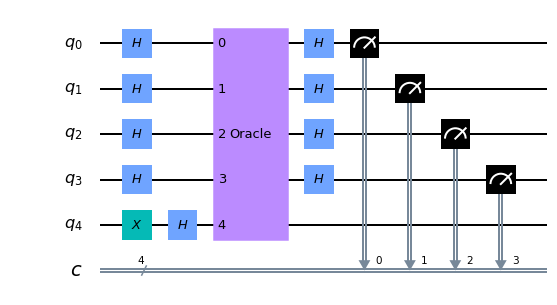

In [11]:
decoherence_percent = 0.1
n = 4
spread = 'balanced' #'balanced' or 'constant'
oracle_gate, none = dj_oracle(spread, n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw(output="mpl")

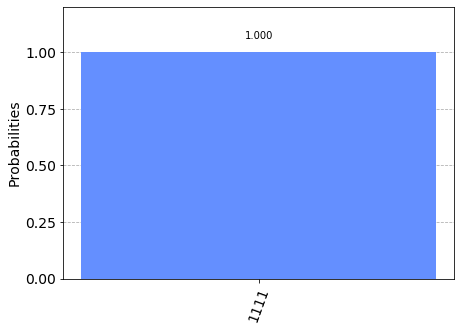

In [12]:
results = execute(dj_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

### Multiple Circuit Runs


In [14]:
trials = 10
decoherence_percent = 0.1
n = 4
spread = 'balanced' #'balanced' or 'constant'
oracle_func = 0 #For printing the oracle later
f = open("trial_results/dj_" + spread +".txt", "w")
dj_mult(spread, n, trials)
f.close()